In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2)))
suppressPackageStartupMessages(suppressWarnings(library(dplyr)))
suppressPackageStartupMessages(suppressWarnings(library(argparse)))
source("../../utils/r_themes.r")

In [ ]:
# Create an ArgumentParser object
parser <- ArgumentParser(description = "UMAP Visualization Script")

# Define the arguments
parser$add_argument("--data_mode", type = "character", help = "data to plot", required = TRUE)
# Parse the arguments
args <- parser$parse_args()

data_mode <- args$data_mode

In [3]:
# set paths 
umap_file_path <- file.path("../../data/umap/",paste0(data_mode,"_umap_transformed.parquet"))
umap_file_path <- normalizePath(umap_file_path)
figures_path <- file.path(paste0("../figures/",data_mode,"/"))
if (!dir.exists(figures_path)) {
  dir.create(figures_path)
}

umap_df <- arrow::read_parquet(umap_file_path)
head(umap_df,1)

Metadata_plate,Metadata_Well,Metadata_number_of_singlecells,Metadata_compound,Metadata_dose,Metadata_control,Metadata_ImageNumber,Metadata_FOV,Metadata_Time,Metadata_Cells_Number_Object_Number,⋯,Metadata_image_path,Metadata_Cells_AreaShape_BoundingBoxArea_CP,Metadata_Image_FileName_CL_488_1_crop,Metadata_Image_FileName_CL_488_2_crop,Metadata_Image_FileName_CL_561_crop,Metadata_Image_FileName_DNA_crop,Metadata_parent_path,UMAP0,UMAP1,__index_level_0__
<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>
1,C-09,168,Staurosporine,39.06,positive,1,0002,0.0,7,⋯,../0.pre-process_images/data/processed_images/sc_crops/C-09_F0002_time_0.0_image_number_1_cell_number_7/C-09_F0002_T0001_Z0001_C01_illumcorrectimage_number_1_cell_number_7_index_2_crop.tiff,-0.3598509,/home/lippincm/4TB_A/live_cell_timelapse_apoptosis_analysis/data/single_cell_crops/C-09_F0002_T0001_Z0001_C02_illumcorrectf_crop_7_0.tiff,/home/lippincm/4TB_A/live_cell_timelapse_apoptosis_analysis/data/single_cell_crops/C-09_F0002_T0001_Z0001_C03_illumcorrectf_crop_7_0.tiff,/home/lippincm/4TB_A/live_cell_timelapse_apoptosis_analysis/data/single_cell_crops/C-09_F0002_T0001_Z0001_C04_illumcorrectf_crop_7_0.tiff,/home/lippincm/4TB_A/live_cell_timelapse_apoptosis_analysis/data/single_cell_crops/C-09_F0002_T0001_Z0001_C01_illumcorrectf_crop_7_0.tiff,/home/lippincm/4TB_A/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/timelapse/20231017ChromaLive_6hr_4ch_MaxIP_C-09_F0002,1.711313,4.580805,0


In [4]:
# replace 0.0 with 0 if needed
umap_df$Metadata_dose <- as.character(umap_df$Metadata_dose)
umap_df$Metadata_dose[umap_df$Metadata_dose == "0.0"] <- "0"

In [5]:
unique(umap_df$Metadata_Time)

[1] "0.0"  "2.0"  "3.0"  "4.0"  "5.0"  "6.0"  "8.0"  "9.0"  "10.0" "11.0"
[11] "12.0" "1.0"  "7.0"

In [6]:
# add nM to the dose column
umap_df$Metadata_dose <- paste0(umap_df$Metadata_dose, " nM")
# make the dose a factor with levels
umap_df$Metadata_dose <- factor(umap_df$Metadata_dose, levels = c(
    "0 nM",
    "0.61 nM",
    "1.22 nM",
    "2.44 nM",
    "4.88 nM",
    "9.77 nM",
    "19.53 nM",
    "39.06 nM",
    "78.13 nM",
    "156.25 nM"
    )
    )

# check if time is a character
if (is.character(umap_df$Metadata_Time)) {
    # check if leading zeros are present
    if (any(grepl("00", umap_df$Metadata_Time))) {

        # make time a factor with levels
        # replace the "T000" with ""
        umap_df$Metadata_Time <- gsub("T00", "", umap_df$Metadata_Time)
        umap_df$Metadata_Time <- gsub("000", "", umap_df$Metadata_Time)
        umap_df$Metadata_Time <- gsub("00", "", umap_df$Metadata_Time)
        umap_df$Metadata_Time <- gsub("0", "", umap_df$Metadata_Time)
    }
}


# make time an integer
umap_df$Metadata_Time <- as.integer(umap_df$Metadata_Time)
if (min(umap_df$Metadata_Time) == 1) {
    umap_df$Metadata_Time <- umap_df$Metadata_Time - 1
}else {
    # do nothing
    
}
# change the Metadata Time columnd to minutes
umap_df$Metadata_Time <- ((umap_df$Metadata_Time)) * 30
# add "min" to the time column
umap_df$Metadata_Time <- paste0(umap_df$Metadata_Time, " min")
# make the metadata time column a factor with levels
umap_df$Metadata_Time <- factor(umap_df$Metadata_Time, levels = c(
    "0 min",
    "30 min",
    "60 min",
    "90 min",
    "120 min",
    "150 min",
    "180 min",
    "210 min",
    "240 min",
    "270 min",
    "300 min",
    "330 min",
    "360 min"
))


NULL

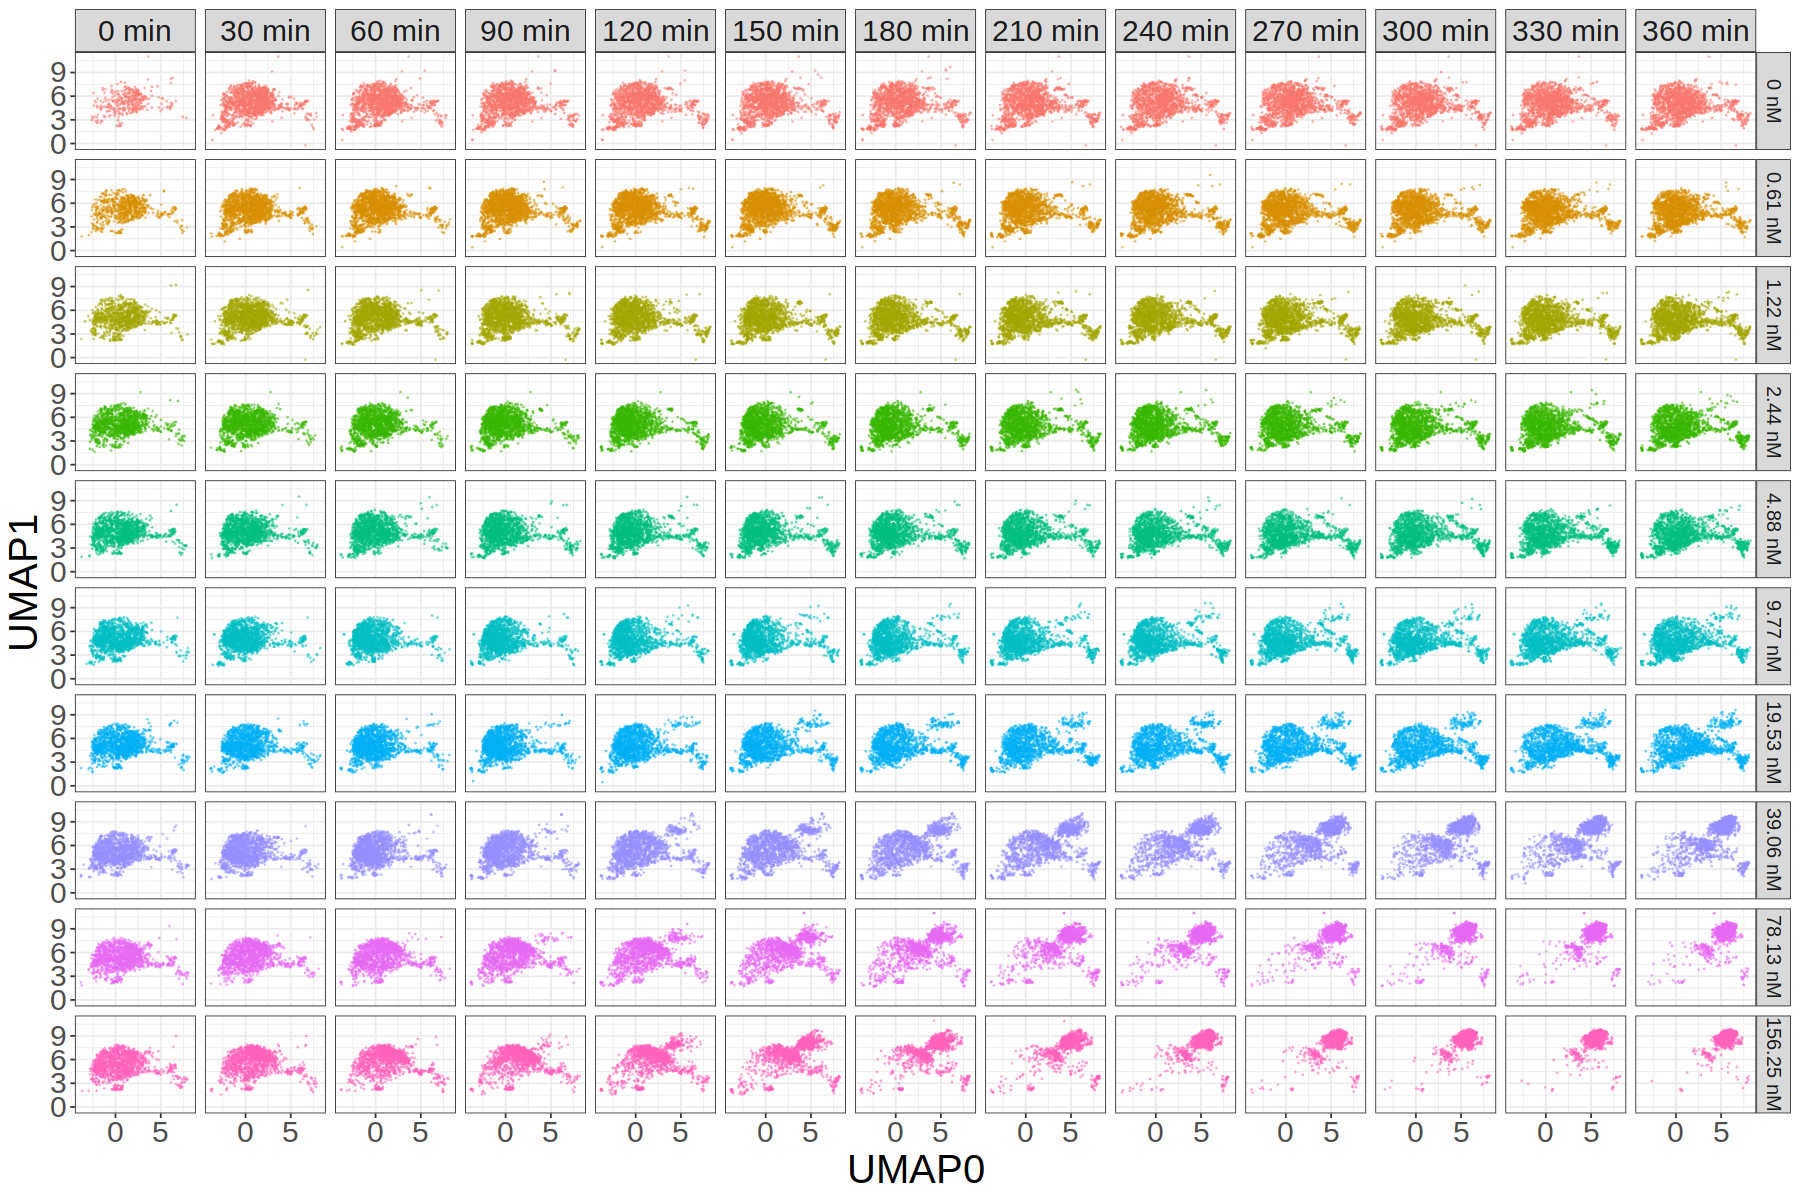

In [7]:
# make a ggplot of the umap
width <- 15
height <- 10
options(repr.plot.width = width, repr.plot.height = height)
umap_plot <- (
    ggplot(data = umap_df, aes(x = UMAP0, y = UMAP1, color = Metadata_dose))
    + geom_point(size = 0.2, alpha = 0.4)
    + theme_bw()
    + facet_grid(Metadata_dose~Metadata_Time)
    
    + labs( x = "UMAP0", y = "UMAP1")
    + theme(
        legend.position = "none", 
        strip.text.x = element_text(size = 18),
        strip.text.y = element_text(size = 12),
        axis.text.x = element_text(size = 18),
        axis.text.y = element_text(size = 18),
        axis.title.x = element_text(size = 24),
        axis.title.y = element_text(size = 24),
        )
)
umap_plot
# save  
ggsave(paste0("../figures/",data_mode,"/umap_plot_time.png"), plot = umap_plot, width = width, height = height, dpi = 600)

`summarise()` has grouped output by 'Metadata_dose'. You can override using the
`.groups` argument.
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


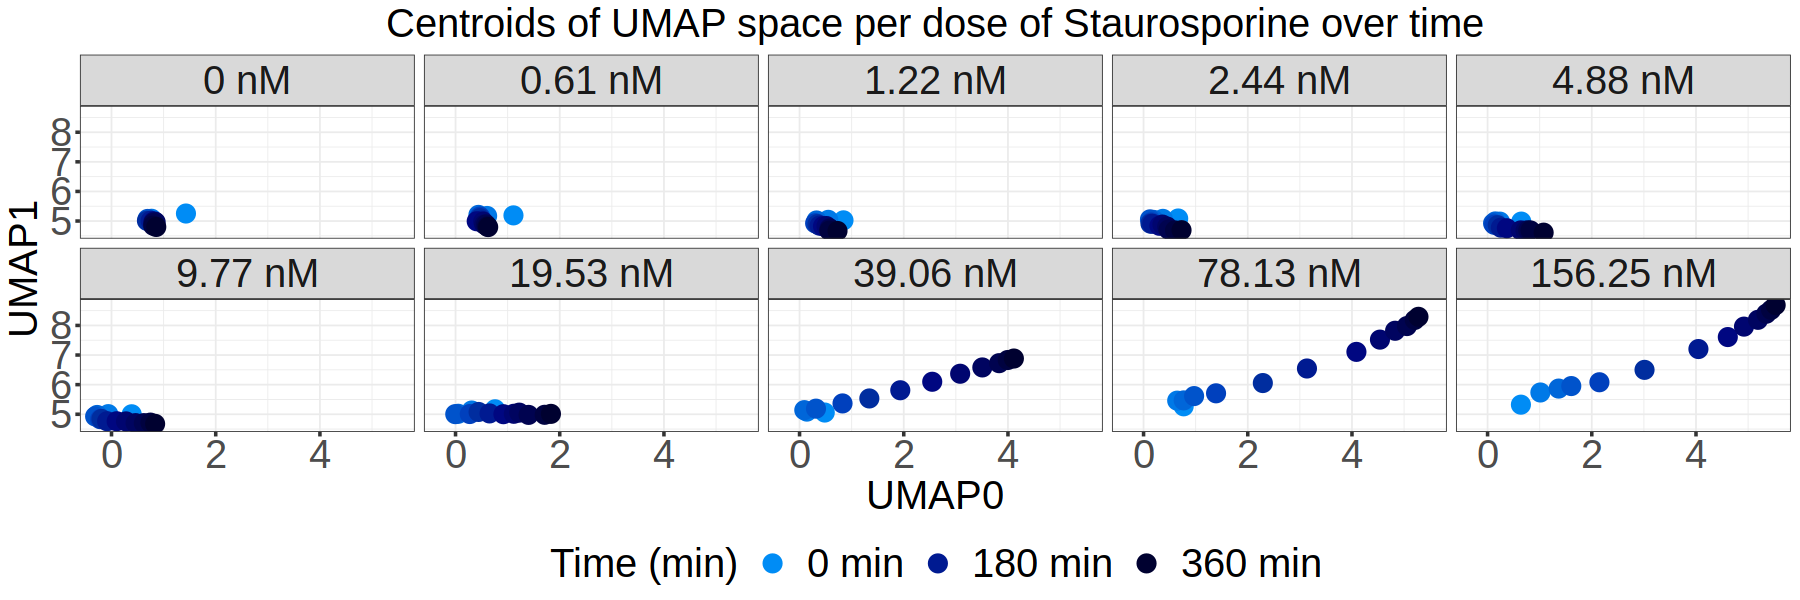

In [8]:
# calculate the centroid of each UMAP cluster dose and time wise
umap_df_centroids <- umap_df %>% group_by(Metadata_dose, Metadata_Time) %>% summarise(
    UMAP0_centroid = mean(UMAP0),
    UMAP1_centroid = mean(UMAP1)
)
umap_df_centroids$Metadata_Time <- as.numeric(gsub(" min", "", umap_df_centroids$Metadata_Time))

width <- 15
height <- 5
options(repr.plot.width = width, repr.plot.height = height)
# plot the centroids per dose over time
umap_centroid_plot <- (
    ggplot(data = umap_df_centroids, aes(x = UMAP0_centroid, y = UMAP1_centroid, color = Metadata_Time))
    + geom_point(size = 5)
    + theme_bw()
    + labs( x = "UMAP0", y = "UMAP1", title = "Centroids of UMAP space per dose of Staurosporine over time")
    # add custom colors
    + scale_color_gradientn(
        colors = temporal_palette,
        breaks = c(0, 180, 360), # breaks at 0, 90, and 360 minutes
        labels = c("0 min", "180 min", "360 min")
    )


    # change legend title
    + guides(
        color = guide_legend(
            title = "Time (min)", hjust = 0.5, ncol = 3
        ),
        size = 5
    )
    + theme(
        strip.text.x = element_text(size = 24),
        strip.text.y = element_text(size = 24),
        axis.text.x = element_text(size = 24),
        axis.text.y = element_text(size = 24),
        axis.title.x = element_text(size = 24),
        axis.title.y = element_text(size = 24),
        axis.ticks.x = element_line(size = 1),
        axis.ticks.y = element_line(size = 1),
        legend.text = element_text(size = 24),
        legend.position = "bottom",
        legend.title = element_text(size = 24, hjust = 0.5),
        plot.title = element_text(size = 24, hjust = 0.5)
        )
    + facet_wrap(~Metadata_dose,nrow = 2)
    
)
umap_centroid_plot
# save
ggsave(paste0("../figures/",data_mode,"/umap_centroid_plot.png"), plot = umap_centroid_plot, width = width, height = height, dpi = 600)

## Select only some of the doeses

In [9]:

# get the first two, middle, and last two doses
dose_levels <- c("0.0 nM", "0.61 nM", "9.77 nM",  "78.13 nM", "156.25 nM")
umap_df <- umap_df %>% filter(Metadata_dose %in% dose_levels)

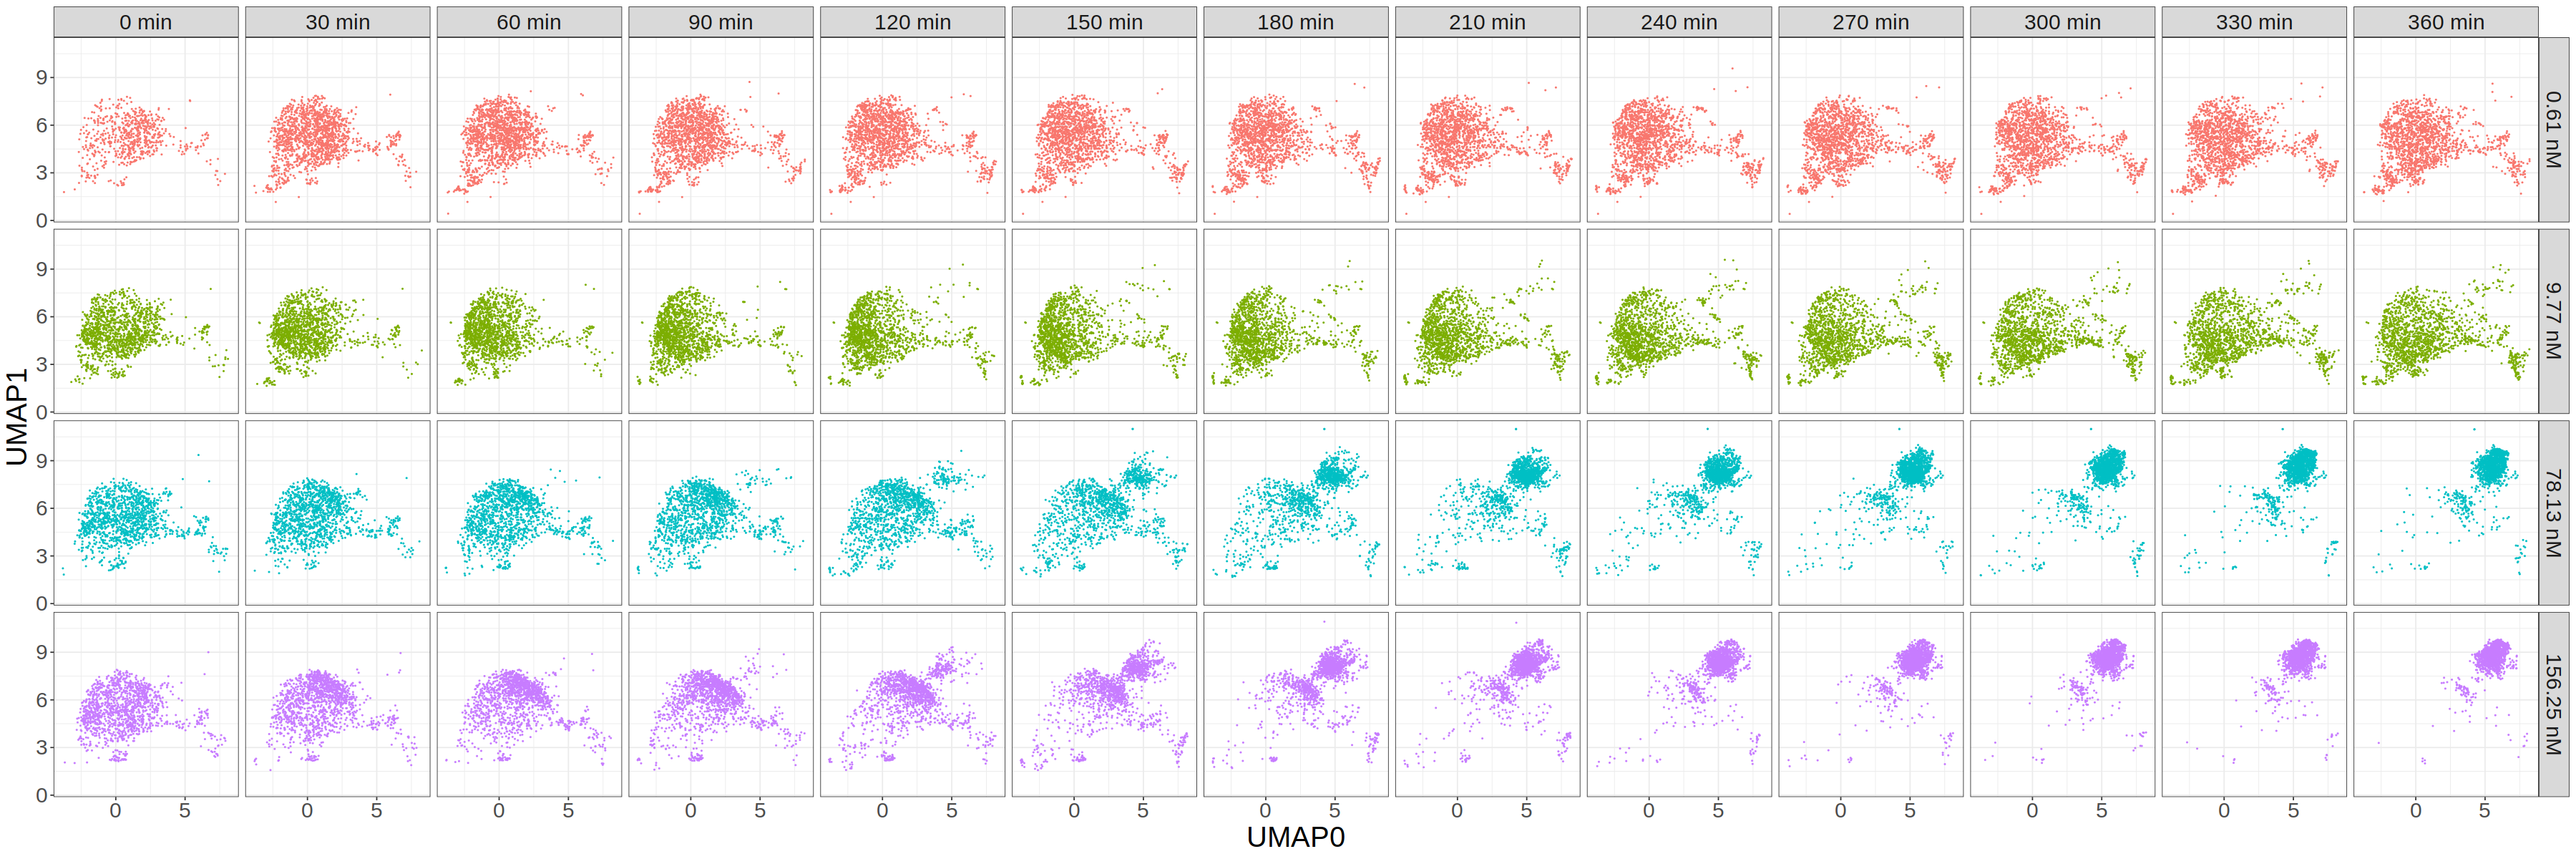

In [10]:
# make a ggplot of the umap
width <- 30
height <- 10
options(repr.plot.width = width, repr.plot.height = height)
umap_plot <- (
    ggplot(data = umap_df, aes(x = UMAP0, y = UMAP1, color = Metadata_dose))
    + geom_point(size = 0.2)
    + theme_bw()
    + facet_grid(Metadata_dose~Metadata_Time)
    
    + labs( x = "UMAP0", y = "UMAP1")
    + theme(
        legend.position = "none", 
        strip.text.x = element_text(size = 18),
        strip.text.y = element_text(size = 18),
        axis.text.x = element_text(size = 18),
        axis.text.y = element_text(size = 18),
        axis.title.x = element_text(size = 24),
        axis.title.y = element_text(size = 24),
        
        )

    
)
umap_plot
# save  
ggsave(paste0("../figures/",data_mode,"/umap_plot_time_part_of_doses.png"), plot = umap_plot, width = width, height = height, dpi = 600)

`summarise()` has grouped output by 'Metadata_dose'. You can override using the
`.groups` argument.


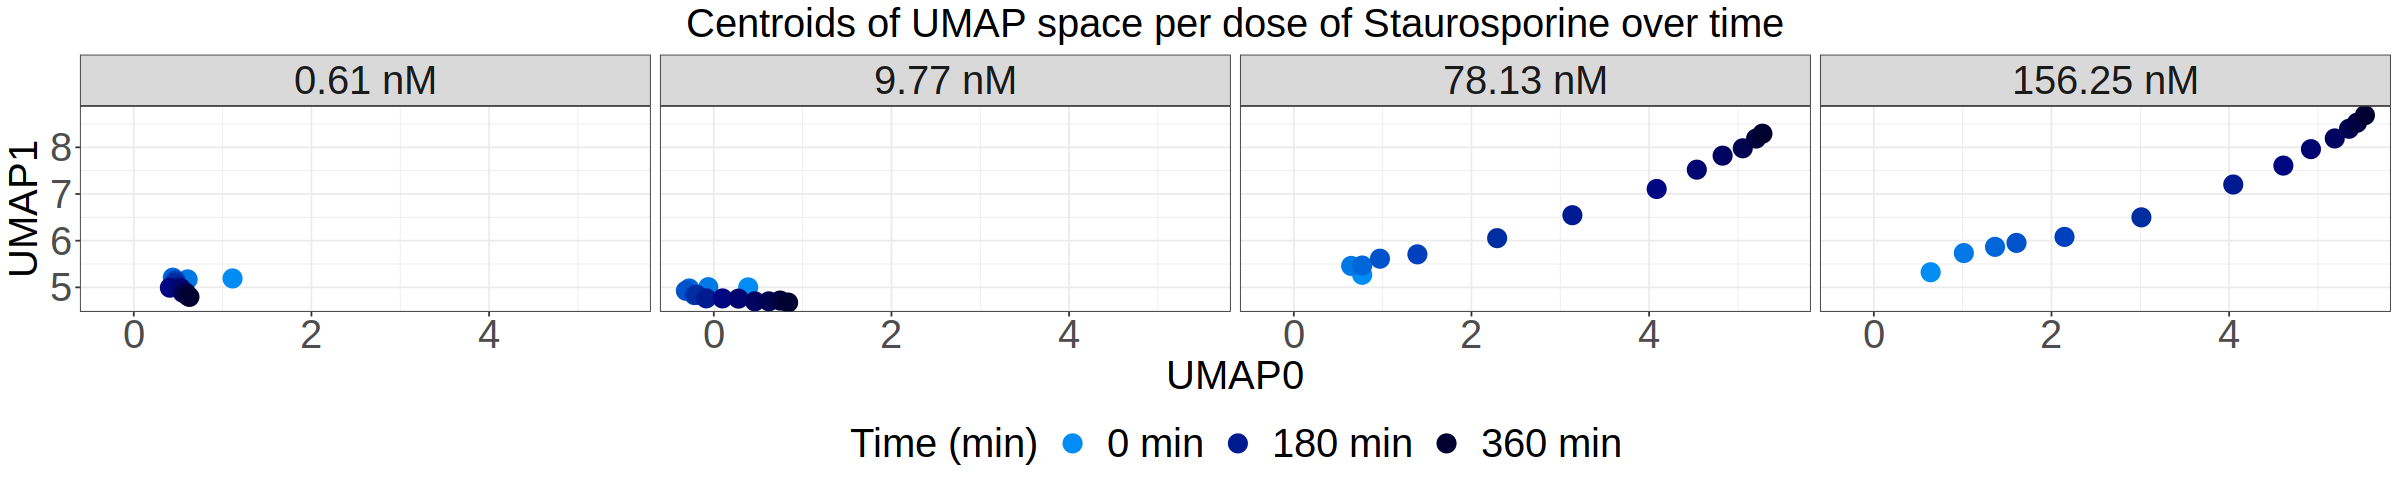

In [11]:
# set temporal colour palette of 13 hues of blue
temporal_palette <- c(
    "#008CF5", "#0079E7", "#0066D9", "#0053CB", "#0040BD", "#002D9F", "#001A91", "#000781", "#000570", "#000460", "#000350", "#000240", "#000130"
)
# calculate the centroid of each UMAP cluster dose and time wise
umap_df_centroids <- umap_df %>% group_by(Metadata_dose, Metadata_Time) %>% summarise(
    UMAP0_centroid = mean(UMAP0),
    UMAP1_centroid = mean(UMAP1)
)
umap_df_centroids$Metadata_Time <- as.numeric(gsub(" min", "", umap_df_centroids$Metadata_Time))

width <- 20
height <- 4
options(repr.plot.width = width, repr.plot.height = height)
# plot the centroids per dose over time
umap_centroid_plot <- (
    ggplot(data = umap_df_centroids, aes(x = UMAP0_centroid, y = UMAP1_centroid, color = Metadata_Time))
    + geom_point(size = 5)
    + theme_bw()
    + labs( x = "UMAP0", y = "UMAP1", title = "Centroids of UMAP space per dose of Staurosporine over time")
    # add a color palette for the doses
    + scale_color_gradientn(
        colors = temporal_palette,
        breaks = c(0, 180, 360), # breaks at 0, 90, and 360 minutes
        labels = c("0 min", "180 min", "360 min")
    )

    # change legend title

    + guides(
        color = guide_legend(
            title = "Time (min)", hjust = 0.5, ncol = 3
        ),
        size = 5
    )   

    + theme(
        strip.text.x = element_text(size = 24),
        strip.text.y = element_text(size = 24),
        axis.text.x = element_text(size = 24),
        axis.text.y = element_text(size = 24),
        axis.title.x = element_text(size = 24),
        axis.title.y = element_text(size = 24),
        legend.text = element_text(size = 24),
        legend.title = element_text(size = 24, hjust = 0.5),
        plot.title = element_text(size = 24, hjust = 0.5),
        legend.position = "bottom",
        legend.box = "horizontal",
        )
    + facet_grid(~Metadata_dose)
    
)
umap_centroid_plot
# save
ggsave(paste0("../figures/",data_mode,"/umap_centroid_plot_part_of_doses.png"), plot = umap_centroid_plot, width = width, height = height, dpi = 600)